In [39]:
from torchvision import transforms, datasets
import torch
import matplotlib.pyplot as plt

In [40]:
IMAGE_SIZE = 16

In [41]:
mnist_transform = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
    ]
)
train_dataset = datasets.MNIST(
    root="./data", train=True, transform=mnist_transform, download=True
)

In [42]:
def showImageList(images):
    # show images side by side
    fig = plt.figure(figsize=(20, 5))
    for i, image in enumerate(images):
        ax = fig.add_subplot(1, len(images), i  + 1)
        ax.axis("off")
        ax.imshow(image.squeeze(), cmap="gray", vmin=0, vmax=1)

20

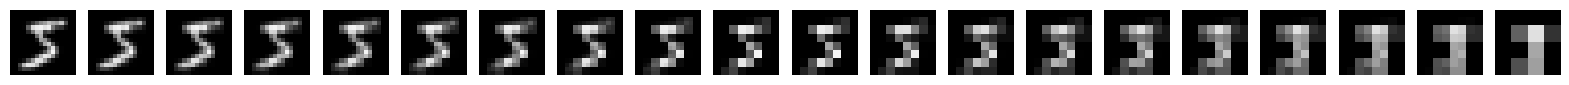

In [43]:
class Pixelate:
    def __init__(
        self,
        n_between: int = 1,
        minimum_pixelation: int = 8,
    ):
        self.n_between = n_between
        self.interpolation = transforms.InterpolationMode.NEAREST
        self.minimum_pixelation = minimum_pixelation

    def calculate_T(self, image_size):
        """
        img0 -> img1/N -> img2/N -> .. -> img(N-1)/N -> img1 -> img(N+1)/N ->... imgK
        Where a fractional image denotes an interpolation between two images (imgA and img(A+1))
        """
        size = image_size
        count = 0
        while size > self.minimum_pixelation:
            count += 1
            size //= 2
        return count * self.n_between

    def __call__(self, images: torch.Tensor, t: int, seed: int = None):
        """
        t = 1 -> no pixelation
        t = T -> full pixelations
        """

        if isinstance(t, torch.Tensor):
            t = t.item()
        image_size = images.shape[-1]

        if seed is not None:
            torch.manual_seed(seed)

        from_index = t // (self.n_between + 1)
        current_level = (t - 1) // self.n_between  # Find out which segment t is in
        relative_t = (
            t - current_level * self.n_between
        )  # Position of t within that segment

        if self.n_between == 1:
            interpolation = 1
        else:
            interpolation = -1 / (self.n_between - 1) * relative_t + self.n_between / (
                self.n_between - 1
            )

        from_size = image_size // (2 ** (from_index + 1))

        from_transform = transforms.Compose(
            [
                transforms.Resize(from_size, self.interpolation),
                transforms.Resize(image_size, self.interpolation),
            ]
        )
        from_images = from_transform(images)

        to_size = image_size // (2 ** (from_index))

        to_transform = transforms.Compose(
            [
                transforms.Resize(to_size, self.interpolation),
                transforms.Resize(image_size, self.interpolation),
            ]
        )

        to_images = to_transform(images)

        return (1 - interpolation) * from_images + interpolation * to_images
        
pixelate = Pixelate(10, 4)

T = pixelate.calculate_T(IMAGE_SIZE)

for i in range(1):
    showImageList([
        pixelate(train_dataset[i][0], t, seed=1) for t in range(1, T + 1)
    ])

len([
        pixelate(train_dataset[0][0], t, seed=1) for t in range(1, T + 1)
    ])

In [44]:
initial_size = 16
minimum_pixelation = 8

int(math.log2(initial_size) - math.log2(minimum_pixelation)) + 1

2

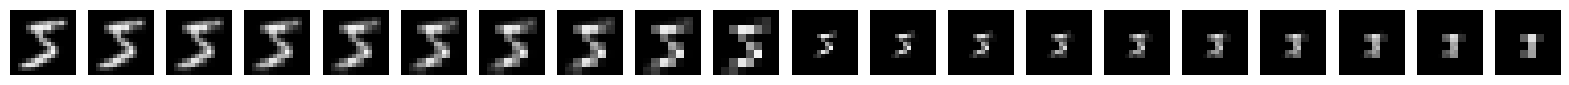

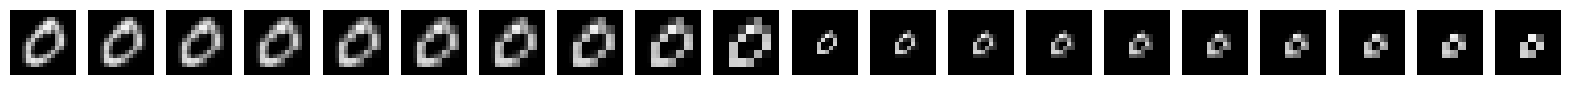

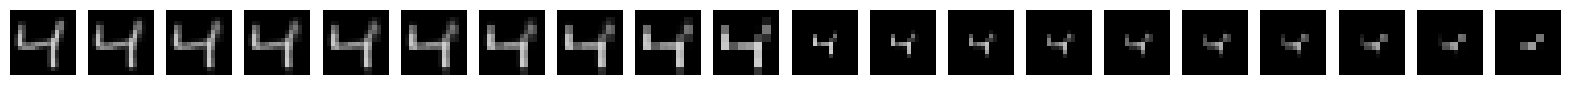

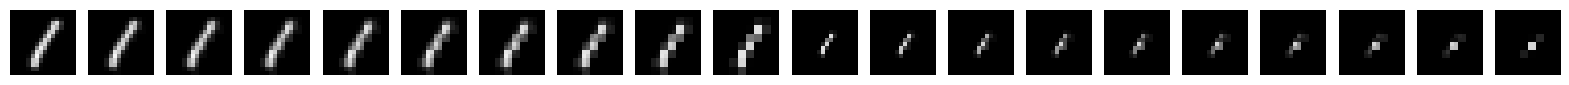

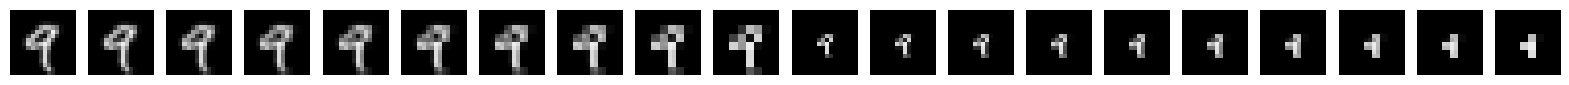

In [63]:
n_between = 10
minimum_pixelation = 4
pixelate = Pixelate(n_between=n_between, minimum_pixelation=minimum_pixelation)
from utils import scale_images
import math


def get_image_time_line(image):
    images = []
    initial_size = image.shape[-1]


    number_of_levels = int(math.log2(initial_size) - math.log2(minimum_pixelation * 2)) + 1

    
    for level in range(0, number_of_levels):
        for relative_t in range(1, n_between + 1):
            # Downscale image
            to_size = initial_size // (2 ** level)
            scaled_image = scale_images(image.unsqueeze(0), to_size)

            # Pixelate image
            pixelated_image = pixelate(scaled_image, relative_t)

            # Pad image
            pad_size = initial_size - pixelated_image.shape[-1]

            pixelated_image = torch.nn.functional.pad(
                pixelated_image,
                pad=(pad_size // 2, pad_size // 2, pad_size // 2, pad_size // 2),
            )

            images.append(pixelated_image)

    return images


for i in range(5):
    showImageList(
        get_image_time_line(train_dataset[i][0])
    )

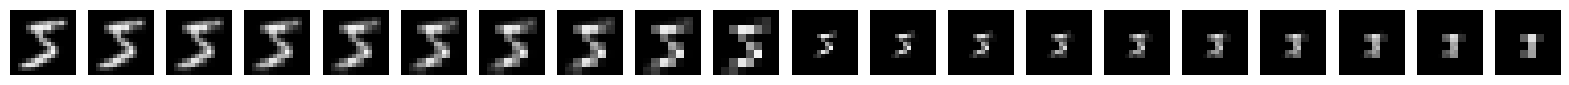

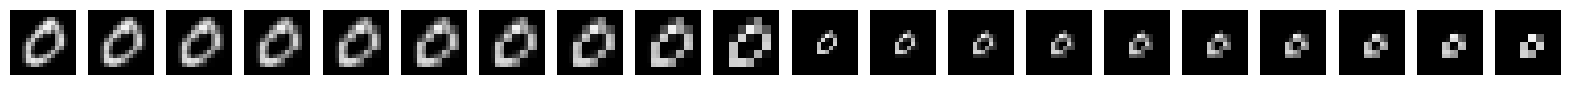

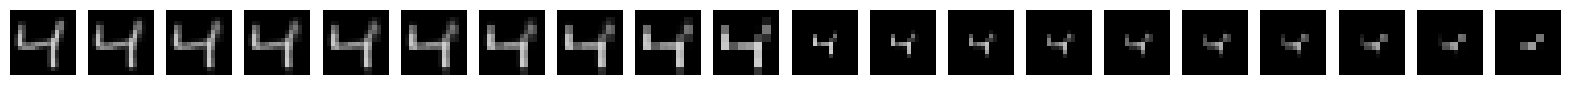

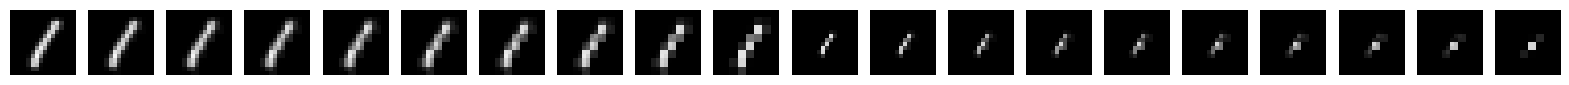

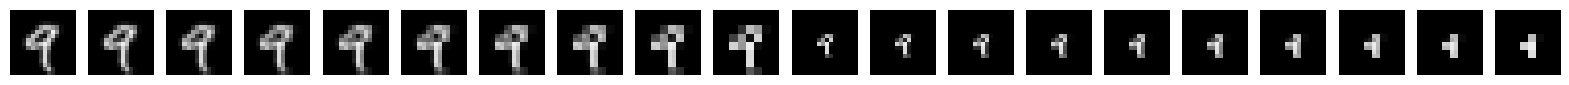

In [62]:
def get_example_sample(image):

    image = image.unsqueeze(0)

    current_size = minimum_pixelation * 2

    x_t = scale_images(image, to_size=minimum_pixelation)
    x_t = scale_images(x_t, to_size=current_size)

    initial_size = image.shape[-1]

    pad_size = initial_size - x_t.shape[-1]

    padded_image = torch.nn.functional.pad(
        x_t,
        pad=(pad_size // 2, pad_size // 2, pad_size // 2, pad_size // 2),
    )

    images = [padded_image]

    
    while current_size <= initial_size:
        for relative_t in range(n_between, 0, -1):

            x_0 = scale_images(image, current_size)

            if relative_t - 1 > 0:
                x_t = (
                    x_t
                    - pixelate(x_0, relative_t)
                    + pixelate(x_0, (relative_t - 1))
                )
            else:
                current_size *= 2
                x_t = scale_images(x_0, current_size)

            

            pad_size = initial_size - x_t.shape[-1]

            padded_image = torch.nn.functional.pad(
                x_t,
                pad=(pad_size // 2, pad_size // 2, pad_size // 2, pad_size // 2),
            )

            images.append(padded_image)


    return images[:-1][::-1]

for i in range(5):
    showImageList(
        get_example_sample(train_dataset[i][0])
    )